In [2]:
import pandas as pd
from collections import defaultdict
import warnings
import visualize
import neat
import multiprocessing
import os
import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()

from random import randint


X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[:1617]
y = digits.target[:1617]

def softmax(x, axis=1):
    # 计算每行的最大值
    row_max = x.max(axis=axis)
 
    # 每行元素都需要减去对应的最大值，否则求exp(x)会溢出，导致inf情况
    row_max=row_max.reshape(-1, 1)
    x = x - row_max
 
    # 计算e的指数次幂
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp, axis=axis, keepdims=True)
    s = x_exp / x_sum
    return s

def get_winner(class1):
    
    numbers = [*range(10)] # number 2 > number 1
    number_of_classification = len(numbers)
    #number_of_sampling = 100

    list_y = y.tolist()
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

        
    class2 = []

    class1_indexes = []
    class2_indexes = []

    for i in numbers:
        if i in class1:
            class1_indexes.extend(digits_indexes[i])
        else:
            class2_indexes.extend(digits_indexes[i])
            class2.append(i)

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)

    print("number of class1:{}".format(len(class1_label)))
    print("number of class2:{}".format(len(class2_label)))

    samplesize = 1617
    x_inputs =[tuple(c) for c in X[class1_indexes].tolist()] + [tuple(c) for c in X[class2_indexes].tolist()]
    x_outputs = [tuple([c]) for c in class1_label + class2_label]
    
    
    def eval_genomes(genomes, config):
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)

            outputs = []
            for xi in x_inputs:
                output = net.activate(xi)
                outputs.append(output)


            px_outputs = softmax(np.array(outputs).reshape(samplesize, 2), axis=1)
            # the index of maximum in each line
            pred_outputs = np.argmax(px_outputs, axis = 1)
            real_outputs = np.array(x_outputs).reshape(samplesize,)

            acc = np.sum(pred_outputs == real_outputs)/samplesize

            genome.fitness = acc

    def run(config_file):
        # Load configuration.
        config = neat.Config(
            neat.DefaultGenome,
            neat.DefaultReproduction,
            neat.DefaultSpeciesSet,
            neat.DefaultStagnation,
            config_file,
        )

        # Create the population, which is the top-level object for a NEAT run.
        p = neat.Population(config)

        # add a stdout reporter to show progress in the terminal
        reporter = neat.StdOutReporter(False)
        p.add_reporter(reporter)
        stats = neat.StatisticsReporter()
        p.add_reporter(stats)
        #checkpointer = neat.Checkpointer(100)
        #p.add_reporter(checkpointer)
        # Run for up to 300 generations.
        winner = p.run(eval_genomes, 3)

        return [stats, winner]
    
    local_dir = os.getcwd()
    config_path = os.path.join(local_dir, "config-feedforward-mnist2")
    [stats, winner] = run(config_path)
    
    return winner

def get_pred_real(i, j):
    winner_net = neat.nn.FeedForwardNetwork.create(winner_list[i], config)
    
    numbers = [*range(10)]
    class1 = classes[i]
    class2 = []
    class1_indexes = []
    class2_indexes = []
    
    test_X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[j]
    test_y = digits.target[j]

    list_y = [test_y]
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

    for i in numbers:
        if i in class1:
            class1_indexes.extend(digits_indexes[i])
        else:
            class2_indexes.extend(digits_indexes[i])
            class2.append(i)

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)


    testsamplesize = 1
    test_x_inputs =[tuple(test_X)]
    test_x_outputs = [tuple([c]) for c in class1_label + class2_label]

    outputs = []
    for xi in test_x_inputs:
        output = winner_net.activate(xi)
        outputs.append(output)

    px_outputs = softmax(np.array(outputs).reshape(testsamplesize, 2), axis=1)
    # the index of maximum in each line
    pred_outputs = np.argmax(px_outputs, axis = 1)
    real_outputs = np.array(test_x_outputs).reshape(testsamplesize,)

    
    return [pred_outputs, real_outputs]

acc_list = []

number_codes = []
for i in range(2**(10-1), 2**10-1):
    for j in bin(i).split('b')[1]:
        number_codes.append(int(j))
number_codes = np.array(number_codes).reshape(2**9 - 1,10).T.tolist()
classes = []
for i in range(2**(10-1) - 1):
    code_list = np.array(number_codes).T[i]
    classes.append(np.where(code_list==1)[0].tolist())

winner_list = []

for class1 in classes:
    winner = get_winner(class1)
    winner_list.append(winner)

local_dir = os.getcwd()
config_path = os.path.join(local_dir, "config-feedforward-mnist2")

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    config_path,
)

pred_value = []
error_list = []

for j in range(1617,1617+180):
    pred = []
    for i in range(511):
        [pred_outputs, real_outputs] = get_pred_real(i, j)
        #print(pred_outputs, real_outputs)
        pred.append(pred_outputs)
    #print(np.array(pred).T)

    error = []
    for i in range(10):
        error.append(511 - np.sum(number_codes[i] == np.array(pred).T))
    #print(error)

    pred_value.append(np.where(error==np.min(error)))
    error_list.append(np.min(error))
    #print(np.where(error==np.min(error)) )

list_P = []
for i in pred_value:
    if (len(i[0])) == 1:
        list_P.append(i[0][0])
    else:
        random_pick = randint(0, len(i[0])-1)
        list_P.append(i[0][random_pick])

acc = np.sum(list_P == digits.target[1617:])/180
print(acc)


number of class1:162
number of class2:1455

 ****** Running generation 0 ****** 

Population's average fitness: 0.61021 stdev: 0.26702
Best fitness: 0.93012 - size: (2, 13) - species 5 - id 173
Average adjusted fitness: 0.498
Mean genetic distance 2.865, standard deviation 0.455
Population of 200 members in 25 species
Total extinctions: 0
Generation time: 5.574 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.75459 stdev: 0.21576
Best fitness: 0.93012 - size: (2, 13) - species 5 - id 173
Average adjusted fitness: 0.624
Mean genetic distance 2.967, standard deviation 0.469
Population of 200 members in 31 species
Total extinctions: 0
Generation time: 5.729 sec (5.652 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.78190 stdev: 0.21361
Best fitness: 0.95857 - size: (3, 16) - species 24 - id 521
Average adjusted fitness: 0.682
Mean genetic distance 2.972, standard deviation 0.461
Population of 202 members in 32 species
Total extinct

Total extinctions: 0
Generation time: 5.685 sec (5.400 average)
number of class1:325
number of class2:1292

 ****** Running generation 0 ****** 

Population's average fitness: 0.56083 stdev: 0.21091
Best fitness: 0.84601 - size: (2, 13) - species 2 - id 123
Average adjusted fitness: 0.495
Mean genetic distance 2.913, standard deviation 0.474
Population of 201 members in 23 species
Total extinctions: 0
Generation time: 5.076 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.69029 stdev: 0.16296
Best fitness: 0.85343 - size: (2, 14) - species 9 - id 301
Average adjusted fitness: 0.486
Mean genetic distance 2.966, standard deviation 0.466
Population of 201 members in 30 species
Total extinctions: 0
Generation time: 5.568 sec (5.322 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.71617 stdev: 0.16120
Best fitness: 0.90476 - size: (3, 16) - species 3 - id 514
Average adjusted fitness: 0.587
Mean genetic distance 3.009, standard deviat


 ****** Running generation 0 ****** 

Population's average fitness: 0.54693 stdev: 0.20372
Best fitness: 0.86827 - size: (2, 13) - species 4 - id 47
Average adjusted fitness: 0.320
Mean genetic distance 2.932, standard deviation 0.493
Population of 201 members in 24 species
Total extinctions: 0
Generation time: 5.169 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.64856 stdev: 0.20372
Best fitness: 0.86827 - size: (2, 13) - species 4 - id 47
Average adjusted fitness: 0.443
Mean genetic distance 3.022, standard deviation 0.482
Population of 201 members in 29 species
Total extinctions: 0
Generation time: 5.468 sec (5.319 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.67243 stdev: 0.19071
Best fitness: 0.87941 - size: (4, 16) - species 1 - id 479
Average adjusted fitness: 0.498
Mean genetic distance 3.045, standard deviation 0.475
Population of 200 members in 32 species
Total extinctions: 0
Generation time: 5.775 sec (5.471 aver

number of class2:1128

 ****** Running generation 0 ****** 

Population's average fitness: 0.53622 stdev: 0.14831
Best fitness: 0.79344 - size: (2, 13) - species 1 - id 162
Average adjusted fitness: 0.307
Mean genetic distance 2.890, standard deviation 0.447
Population of 200 members in 23 species
Total extinctions: 0
Generation time: 5.250 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.61987 stdev: 0.13232
Best fitness: 0.82560 - size: (3, 14) - species 18 - id 301
Average adjusted fitness: 0.351
Mean genetic distance 3.020, standard deviation 0.448
Population of 200 members in 31 species
Total extinctions: 0
Generation time: 6.340 sec (5.795 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.63201 stdev: 0.14192
Best fitness: 0.82560 - size: (3, 14) - species 18 - id 301
Average adjusted fitness: 0.455
Mean genetic distance 3.054, standard deviation 0.441
Population of 201 members in 35 species
Total extinctions: 0
Generation t


 ****** Running generation 0 ****** 

Population's average fitness: 0.54113 stdev: 0.23089
Best fitness: 0.85467 - size: (2, 13) - species 1 - id 21
Average adjusted fitness: 0.421
Mean genetic distance 2.890, standard deviation 0.469
Population of 199 members in 21 species
Total extinctions: 0
Generation time: 5.128 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.68068 stdev: 0.17249
Best fitness: 0.85467 - size: (2, 13) - species 1 - id 21
Average adjusted fitness: 0.464
Mean genetic distance 2.958, standard deviation 0.479
Population of 200 members in 23 species
Total extinctions: 0
Generation time: 5.605 sec (5.367 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.70499 stdev: 0.17023
Best fitness: 0.89425 - size: (4, 17) - species 12 - id 492
Average adjusted fitness: 0.516
Mean genetic distance 2.962, standard deviation 0.461
Population of 200 members in 29 species
Total extinctions: 0
Generation time: 5.884 sec (5.539 ave

Mean genetic distance 3.113, standard deviation 0.507
Population of 203 members in 35 species
Total extinctions: 0
Generation time: 7.315 sec (6.701 average)
number of class1:486
number of class2:1131

 ****** Running generation 0 ****** 

Population's average fitness: 0.57119 stdev: 0.15320
Best fitness: 0.88992 - size: (2, 13) - species 7 - id 50
Average adjusted fitness: 0.475
Mean genetic distance 2.865, standard deviation 0.488
Population of 200 members in 19 species
Total extinctions: 0
Generation time: 5.758 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.61531 stdev: 0.15261
Best fitness: 0.88992 - size: (2, 13) - species 7 - id 50
Average adjusted fitness: 0.391
Mean genetic distance 3.008, standard deviation 0.473
Population of 199 members in 26 species
Total extinctions: 0
Generation time: 5.531 sec (5.645 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.65034 stdev: 0.14783
Best fitness: 0.88992 - size: (2, 13) - spe

number of class2:1130

 ****** Running generation 0 ****** 

Population's average fitness: 0.53268 stdev: 0.14564
Best fitness: 0.79654 - size: (2, 13) - species 5 - id 38
Average adjusted fitness: 0.272
Mean genetic distance 2.896, standard deviation 0.504
Population of 200 members in 22 species
Total extinctions: 0
Generation time: 5.955 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.60986 stdev: 0.13588
Best fitness: 0.79963 - size: (2, 13) - species 1 - id 316
Average adjusted fitness: 0.365
Mean genetic distance 2.916, standard deviation 0.487
Population of 200 members in 27 species
Total extinctions: 0
Generation time: 5.792 sec (5.873 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.63696 stdev: 0.12261
Best fitness: 0.81200 - size: (3, 14) - species 21 - id 532
Average adjusted fitness: 0.346
Mean genetic distance 2.979, standard deviation 0.480
Population of 199 members in 29 species
Total extinctions: 0
Generation tim

Mean genetic distance 3.059, standard deviation 0.444
Population of 200 members in 37 species
Total extinctions: 0
Generation time: 7.844 sec (6.322 average)
number of class1:650
number of class2:967

 ****** Running generation 0 ****** 

Population's average fitness: 0.51823 stdev: 0.11843
Best fitness: 0.79839 - size: (2, 13) - species 1 - id 56
Average adjusted fitness: 0.337
Mean genetic distance 2.853, standard deviation 0.468
Population of 200 members in 19 species
Total extinctions: 0
Generation time: 8.025 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.57712 stdev: 0.11510
Best fitness: 0.82437 - size: (3, 15) - species 3 - id 313
Average adjusted fitness: 0.347
Mean genetic distance 3.087, standard deviation 0.512
Population of 201 members in 25 species
Total extinctions: 0
Generation time: 7.877 sec (7.951 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.58434 stdev: 0.12194
Best fitness: 0.82437 - size: (3, 15) - spe

Population's average fitness: 0.59925 stdev: 0.14304
Best fitness: 0.80087 - size: (2, 13) - species 22 - id 129
Average adjusted fitness: 0.345
Mean genetic distance 3.098, standard deviation 0.501
Population of 202 members in 33 species
Total extinctions: 0
Generation time: 5.617 sec (5.348 average)
number of class1:327
number of class2:1290

 ****** Running generation 0 ****** 

Population's average fitness: 0.54510 stdev: 0.20481
Best fitness: 0.81076 - size: (2, 13) - species 3 - id 132
Average adjusted fitness: 0.312
Mean genetic distance 2.869, standard deviation 0.471
Population of 200 members in 23 species
Total extinctions: 0
Generation time: 5.047 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.67804 stdev: 0.17284
Best fitness: 0.87199 - size: (2, 14) - species 5 - id 320
Average adjusted fitness: 0.468
Mean genetic distance 2.929, standard deviation 0.454
Population of 199 members in 28 species
Total extinctions: 0
Generation time: 5.414 sec (5.2

Population's average fitness: 0.55546 stdev: 0.08698
Best fitness: 0.81509 - size: (4, 16) - species 2 - id 539
Average adjusted fitness: 0.328
Mean genetic distance 3.002, standard deviation 0.479
Population of 204 members in 32 species
Total extinctions: 0
Generation time: 5.769 sec (5.479 average)
number of class1:490
number of class2:1127

 ****** Running generation 0 ****** 

Population's average fitness: 0.54153 stdev: 0.14455
Best fitness: 0.76252 - size: (2, 13) - species 2 - id 105
Average adjusted fitness: 0.323
Mean genetic distance 2.904, standard deviation 0.448
Population of 201 members in 25 species
Total extinctions: 0
Generation time: 5.168 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.64010 stdev: 0.10717
Best fitness: 0.81818 - size: (3, 14) - species 2 - id 356
Average adjusted fitness: 0.346
Mean genetic distance 3.038, standard deviation 0.465
Population of 200 members in 34 species
Total extinctions: 0
Generation time: 5.611 sec (5.39

Population's average fitness: 0.56886 stdev: 0.08887
Best fitness: 0.77180 - size: (2, 14) - species 4 - id 541
Average adjusted fitness: 0.295
Mean genetic distance 3.050, standard deviation 0.474
Population of 199 members in 30 species
Total extinctions: 0
Generation time: 6.140 sec (5.608 average)
number of class1:491
number of class2:1126

 ****** Running generation 0 ****** 

Population's average fitness: 0.53656 stdev: 0.15133
Best fitness: 0.74397 - size: (2, 13) - species 5 - id 27
Average adjusted fitness: 0.299
Mean genetic distance 2.904, standard deviation 0.472
Population of 200 members in 22 species
Total extinctions: 0
Generation time: 5.219 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.60811 stdev: 0.12774
Best fitness: 0.77489 - size: (3, 14) - species 1 - id 364
Average adjusted fitness: 0.323
Mean genetic distance 2.984, standard deviation 0.493
Population of 199 members in 25 species
Total extinctions: 0
Generation time: 5.536 sec (5.378

Population's average fitness: 0.57305 stdev: 0.11302
Best fitness: 0.80025 - size: (2, 13) - species 6 - id 193
Average adjusted fitness: 0.333
Mean genetic distance 2.950, standard deviation 0.460
Population of 200 members in 30 species
Total extinctions: 0
Generation time: 5.748 sec (5.484 average)
number of class1:654
number of class2:963

 ****** Running generation 0 ****** 

Population's average fitness: 0.52307 stdev: 0.08996
Best fitness: 0.71490 - size: (2, 13) - species 1 - id 95
Average adjusted fitness: 0.222
Mean genetic distance 2.924, standard deviation 0.501
Population of 199 members in 23 species
Total extinctions: 0
Generation time: 5.167 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.56482 stdev: 0.10091
Best fitness: 0.75201 - size: (3, 15) - species 3 - id 230
Average adjusted fitness: 0.265
Mean genetic distance 3.034, standard deviation 0.526
Population of 201 members in 29 species
Total extinctions: 0
Generation time: 5.644 sec (5.406 

Population's average fitness: 0.61701 stdev: 0.13044
Best fitness: 0.80025 - size: (3, 14) - species 2 - id 387
Average adjusted fitness: 0.310
Mean genetic distance 3.037, standard deviation 0.485
Population of 194 members in 33 species
Total extinctions: 0
Generation time: 6.376 sec (5.885 average)
number of class1:488
number of class2:1129

 ****** Running generation 0 ****** 

Population's average fitness: 0.55861 stdev: 0.13736
Best fitness: 0.76067 - size: (2, 13) - species 3 - id 47
Average adjusted fitness: 0.292
Mean genetic distance 2.909, standard deviation 0.469
Population of 200 members in 26 species
Total extinctions: 0
Generation time: 5.363 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.60825 stdev: 0.13317
Best fitness: 0.78231 - size: (3, 14) - species 2 - id 351
Average adjusted fitness: 0.368
Mean genetic distance 2.980, standard deviation 0.496
Population of 200 members in 33 species
Total extinctions: 0
Generation time: 5.565 sec (5.464

Population's average fitness: 0.57196 stdev: 0.08837
Best fitness: 0.79901 - size: (3, 15) - species 4 - id 543
Average adjusted fitness: 0.215
Mean genetic distance 2.969, standard deviation 0.448
Population of 199 members in 30 species
Total extinctions: 0
Generation time: 5.894 sec (5.535 average)
number of class1:651
number of class2:966

 ****** Running generation 0 ****** 

Population's average fitness: 0.51910 stdev: 0.09178
Best fitness: 0.75510 - size: (2, 13) - species 2 - id 170
Average adjusted fitness: 0.233
Mean genetic distance 2.860, standard deviation 0.439
Population of 201 members in 18 species
Total extinctions: 0
Generation time: 5.219 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.55664 stdev: 0.09928
Best fitness: 0.77242 - size: (3, 15) - species 2 - id 383
Average adjusted fitness: 0.294
Mean genetic distance 2.906, standard deviation 0.463
Population of 199 members in 21 species
Total extinctions: 0
Generation time: 5.547 sec (5.383

Population's average fitness: 0.58009 stdev: 0.14465
Best fitness: 0.77365 - size: (2, 14) - species 5 - id 451
Average adjusted fitness: 0.303
Mean genetic distance 3.026, standard deviation 0.492
Population of 197 members in 32 species
Total extinctions: 0
Generation time: 5.550 sec (5.349 average)
number of class1:652
number of class2:965

 ****** Running generation 0 ****** 

Population's average fitness: 0.52336 stdev: 0.08199
Best fitness: 0.72171 - size: (2, 13) - species 2 - id 182
Average adjusted fitness: 0.220
Mean genetic distance 2.971, standard deviation 0.490
Population of 201 members in 28 species
Total extinctions: 0
Generation time: 5.155 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.55389 stdev: 0.08332
Best fitness: 0.72171 - size: (2, 13) - species 2 - id 182
Average adjusted fitness: 0.228
Mean genetic distance 3.079, standard deviation 0.484
Population of 201 members in 32 species
Total extinctions: 0
Generation time: 5.586 sec (5.371

Population's average fitness: 0.60152 stdev: 0.14076
Best fitness: 0.80581 - size: (2, 13) - species 9 - id 21
Average adjusted fitness: 0.354
Mean genetic distance 2.998, standard deviation 0.488
Population of 204 members in 27 species
Total extinctions: 0
Generation time: 5.771 sec (5.539 average)
number of class1:815
number of class2:802

 ****** Running generation 0 ****** 

Population's average fitness: 0.49856 stdev: 0.06717
Best fitness: 0.71923 - size: (2, 13) - species 4 - id 168
Average adjusted fitness: 0.207
Mean genetic distance 2.944, standard deviation 0.505
Population of 200 members in 20 species
Total extinctions: 0
Generation time: 5.198 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.52744 stdev: 0.06829
Best fitness: 0.71923 - size: (2, 13) - species 4 - id 168
Average adjusted fitness: 0.148
Mean genetic distance 2.996, standard deviation 0.531
Population of 201 members in 22 species
Total extinctions: 0
Generation time: 5.560 sec (5.379 

Population's average fitness: 0.63829 stdev: 0.18994
Best fitness: 0.83859 - size: (3, 14) - species 16 - id 318
Average adjusted fitness: 0.476
Mean genetic distance 2.933, standard deviation 0.494
Population of 203 members in 25 species
Total extinctions: 0
Generation time: 5.772 sec (5.465 average)
number of class1:322
number of class2:1295

 ****** Running generation 0 ****** 

Population's average fitness: 0.55216 stdev: 0.20995
Best fitness: 0.82127 - size: (2, 13) - species 6 - id 80
Average adjusted fitness: 0.322
Mean genetic distance 2.951, standard deviation 0.453
Population of 198 members in 32 species
Total extinctions: 0
Generation time: 5.121 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.66487 stdev: 0.18026
Best fitness: 0.82127 - size: (2, 13) - species 6 - id 80
Average adjusted fitness: 0.440
Mean genetic distance 3.005, standard deviation 0.469
Population of 204 members in 35 species
Total extinctions: 0
Generation time: 5.463 sec (5.292

Population's average fitness: 0.55249 stdev: 0.06052
Best fitness: 0.68955 - size: (3, 15) - species 4 - id 381
Average adjusted fitness: 0.164
Mean genetic distance 2.985, standard deviation 0.522
Population of 204 members in 29 species
Total extinctions: 0
Generation time: 5.674 sec (5.505 average)
number of class1:485
number of class2:1132

 ****** Running generation 0 ****** 

Population's average fitness: 0.54165 stdev: 0.14898
Best fitness: 0.78912 - size: (2, 13) - species 1 - id 200
Average adjusted fitness: 0.367
Mean genetic distance 2.892, standard deviation 0.494
Population of 202 members in 21 species
Total extinctions: 0
Generation time: 5.149 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.62268 stdev: 0.13217
Best fitness: 0.87817 - size: (3, 14) - species 2 - id 342
Average adjusted fitness: 0.331
Mean genetic distance 3.003, standard deviation 0.507
Population of 199 members in 29 species
Total extinctions: 0
Generation time: 5.660 sec (5.40

Population's average fitness: 0.55504 stdev: 0.07659
Best fitness: 0.70810 - size: (3, 15) - species 10 - id 535
Average adjusted fitness: 0.186
Mean genetic distance 3.063, standard deviation 0.511
Population of 200 members in 27 species
Total extinctions: 0
Generation time: 5.872 sec (5.534 average)
number of class1:486
number of class2:1131

 ****** Running generation 0 ****** 

Population's average fitness: 0.52631 stdev: 0.14790
Best fitness: 0.76623 - size: (2, 13) - species 1 - id 151
Average adjusted fitness: 0.297
Mean genetic distance 2.944, standard deviation 0.486
Population of 201 members in 29 species
Total extinctions: 0
Generation time: 5.279 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.61560 stdev: 0.12568
Best fitness: 0.76623 - size: (2, 13) - species 1 - id 151
Average adjusted fitness: 0.383
Mean genetic distance 2.990, standard deviation 0.502
Population of 202 members in 31 species
Total extinctions: 0
Generation time: 5.610 sec (5.4

Population's average fitness: 0.57033 stdev: 0.09558
Best fitness: 0.76129 - size: (4, 16) - species 1 - id 544
Average adjusted fitness: 0.224
Mean genetic distance 3.103, standard deviation 0.500
Population of 203 members in 24 species
Total extinctions: 0
Generation time: 5.942 sec (5.578 average)
number of class1:649
number of class2:968

 ****** Running generation 0 ****** 

Population's average fitness: 0.51343 stdev: 0.09110
Best fitness: 0.71676 - size: (2, 13) - species 9 - id 146
Average adjusted fitness: 0.240
Mean genetic distance 2.871, standard deviation 0.497
Population of 200 members in 21 species
Total extinctions: 0
Generation time: 5.178 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.56789 stdev: 0.09007
Best fitness: 0.74212 - size: (2, 13) - species 2 - id 236
Average adjusted fitness: 0.230
Mean genetic distance 2.935, standard deviation 0.458
Population of 201 members in 25 species
Total extinctions: 0
Generation time: 5.564 sec (5.371

Total extinctions: 0
Generation time: 5.583 sec (5.382 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.59312 stdev: 0.14770
Best fitness: 0.81447 - size: (2, 13) - species 8 - id 61
Average adjusted fitness: 0.368
Mean genetic distance 2.972, standard deviation 0.490
Population of 200 members in 27 species
Total extinctions: 0
Generation time: 5.824 sec (5.529 average)
number of class1:483
number of class2:1134

 ****** Running generation 0 ****** 

Population's average fitness: 0.53255 stdev: 0.15569
Best fitness: 0.77860 - size: (2, 13) - species 1 - id 40
Average adjusted fitness: 0.295
Mean genetic distance 2.920, standard deviation 0.483
Population of 200 members in 25 species
Total extinctions: 0
Generation time: 5.944 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.61568 stdev: 0.13345
Best fitness: 0.80025 - size: (2, 14) - species 20 - id 328
Average adjusted fitness: 0.362
Mean genetic distance 3.018, standard deviati


 ****** Running generation 2 ****** 

Population's average fitness: 0.54591 stdev: 0.09028
Best fitness: 0.75448 - size: (3, 15) - species 20 - id 358
Average adjusted fitness: 0.246
Mean genetic distance 2.961, standard deviation 0.490
Population of 202 members in 32 species
Total extinctions: 0
Generation time: 5.867 sec (5.702 average)
number of class1:646
number of class2:971

 ****** Running generation 0 ****** 

Population's average fitness: 0.51702 stdev: 0.10741
Best fitness: 0.76252 - size: (2, 13) - species 2 - id 10
Average adjusted fitness: 0.263
Mean genetic distance 2.835, standard deviation 0.478
Population of 200 members in 18 species
Total extinctions: 0
Generation time: 5.148 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.56431 stdev: 0.09404
Best fitness: 0.76252 - size: (2, 13) - species 2 - id 10
Average adjusted fitness: 0.222
Mean genetic distance 2.945, standard deviation 0.505
Population of 202 members in 23 species
Total extinction


Population's average fitness: 0.58346 stdev: 0.14040
Best fitness: 0.75881 - size: (4, 16) - species 21 - id 520
Average adjusted fitness: 0.301
Mean genetic distance 3.008, standard deviation 0.506
Population of 203 members in 33 species
Total extinctions: 0
Generation time: 5.974 sec (5.672 average)
number of class1:647
number of class2:970

 ****** Running generation 0 ****** 

Population's average fitness: 0.52156 stdev: 0.08744
Best fitness: 0.69079 - size: (2, 13) - species 3 - id 90
Average adjusted fitness: 0.211
Mean genetic distance 2.914, standard deviation 0.488
Population of 201 members in 20 species
Total extinctions: 0
Generation time: 5.214 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.56771 stdev: 0.07982
Best fitness: 0.73036 - size: (3, 15) - species 2 - id 248
Average adjusted fitness: 0.255
Mean genetic distance 2.973, standard deviation 0.488
Population of 203 members in 25 species
Total extinctions: 0
Generation time: 5.569 sec (5.39

Population's average fitness: 0.58708 stdev: 0.13829
Best fitness: 0.77551 - size: (4, 17) - species 5 - id 499
Average adjusted fitness: 0.300
Mean genetic distance 2.926, standard deviation 0.469
Population of 199 members in 31 species
Total extinctions: 0
Generation time: 5.836 sec (5.538 average)
number of class1:810
number of class2:807

 ****** Running generation 0 ****** 

Population's average fitness: 0.50651 stdev: 0.07346
Best fitness: 0.76190 - size: (2, 13) - species 1 - id 75
Average adjusted fitness: 0.264
Mean genetic distance 2.859, standard deviation 0.464
Population of 199 members in 22 species
Total extinctions: 0
Generation time: 5.207 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.53896 stdev: 0.07844
Best fitness: 0.76190 - size: (2, 13) - species 1 - id 75
Average adjusted fitness: 0.225
Mean genetic distance 2.919, standard deviation 0.449
Population of 199 members in 30 species
Total extinctions: 0
Generation time: 5.460 sec (5.334 a

Population's average fitness: 0.66339 stdev: 0.18763
Best fitness: 0.82746 - size: (2, 13) - species 3 - id 20
Average adjusted fitness: 0.431
Mean genetic distance 2.976, standard deviation 0.484
Population of 205 members in 33 species
Total extinctions: 0
Generation time: 5.873 sec (5.529 average)
number of class1:487
number of class2:1130

 ****** Running generation 0 ****** 

Population's average fitness: 0.56914 stdev: 0.13420
Best fitness: 0.77613 - size: (2, 13) - species 4 - id 9
Average adjusted fitness: 0.272
Mean genetic distance 2.952, standard deviation 0.475
Population of 200 members in 23 species
Total extinctions: 0
Generation time: 5.159 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.61992 stdev: 0.12257
Best fitness: 0.79963 - size: (3, 15) - species 4 - id 291
Average adjusted fitness: 0.343
Mean genetic distance 2.962, standard deviation 0.456
Population of 202 members in 27 species
Total extinctions: 0
Generation time: 5.556 sec (5.357 a

Generation time: 5.572 sec (5.411 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.56522 stdev: 0.11074
Best fitness: 0.82808 - size: (3, 15) - species 8 - id 519
Average adjusted fitness: 0.285
Mean genetic distance 2.902, standard deviation 0.423
Population of 205 members in 35 species
Total extinctions: 0
Generation time: 5.845 sec (5.555 average)
number of class1:650
number of class2:967

 ****** Running generation 0 ****** 

Population's average fitness: 0.52466 stdev: 0.08412
Best fitness: 0.68646 - size: (2, 13) - species 3 - id 192
Average adjusted fitness: 0.169
Mean genetic distance 2.845, standard deviation 0.429
Population of 200 members in 23 species
Total extinctions: 0
Generation time: 5.206 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.54491 stdev: 0.09668
Best fitness: 0.71738 - size: (3, 14) - species 7 - id 261
Average adjusted fitness: 0.234
Mean genetic distance 2.925, standard deviation 0.459
Population o

Population's average fitness: 0.61052 stdev: 0.13434
Best fitness: 0.82251 - size: (2, 14) - species 10 - id 363
Average adjusted fitness: 0.334
Mean genetic distance 3.083, standard deviation 0.488
Population of 201 members in 35 species
Total extinctions: 0
Generation time: 5.822 sec (5.568 average)
number of class1:651
number of class2:966

 ****** Running generation 0 ****** 

Population's average fitness: 0.50875 stdev: 0.09381
Best fitness: 0.68646 - size: (2, 13) - species 3 - id 70
Average adjusted fitness: 0.221
Mean genetic distance 2.876, standard deviation 0.470
Population of 200 members in 22 species
Total extinctions: 0
Generation time: 5.219 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.56748 stdev: 0.08835
Best fitness: 0.72171 - size: (2, 11) - species 1 - id 239
Average adjusted fitness: 0.233
Mean genetic distance 2.970, standard deviation 0.485
Population of 201 members in 27 species
Total extinctions: 0
Generation time: 5.546 sec (5.382


 ****** Running generation 2 ****** 

Population's average fitness: 0.59297 stdev: 0.15706
Best fitness: 0.84848 - size: (4, 17) - species 16 - id 439
Average adjusted fitness: 0.362
Mean genetic distance 3.009, standard deviation 0.520
Population of 201 members in 26 species
Total extinctions: 0
Generation time: 5.926 sec (5.602 average)
number of class1:814
number of class2:803

 ****** Running generation 0 ****** 

Population's average fitness: 0.49903 stdev: 0.07537
Best fitness: 0.72480 - size: (2, 13) - species 2 - id 180
Average adjusted fitness: 0.268
Mean genetic distance 2.809, standard deviation 0.461
Population of 200 members in 16 species
Total extinctions: 0
Generation time: 5.267 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.54575 stdev: 0.07742
Best fitness: 0.77613 - size: (2, 14) - species 4 - id 367
Average adjusted fitness: 0.222
Mean genetic distance 3.023, standard deviation 0.493
Population of 202 members in 29 species
Total extincti

Generation time: 5.659 sec (5.533 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.59847 stdev: 0.22637
Best fitness: 0.88250 - size: (4, 16) - species 14 - id 504
Average adjusted fitness: 0.424
Mean genetic distance 3.002, standard deviation 0.455
Population of 204 members in 36 species
Total extinctions: 0
Generation time: 6.191 sec (5.752 average)
number of class1:648
number of class2:969

 ****** Running generation 0 ****** 

Population's average fitness: 0.53313 stdev: 0.08013
Best fitness: 0.70315 - size: (2, 13) - species 2 - id 135
Average adjusted fitness: 0.188
Mean genetic distance 2.920, standard deviation 0.499
Population of 198 members in 22 species
Total extinctions: 0
Generation time: 5.267 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.56680 stdev: 0.07721
Best fitness: 0.72047 - size: (3, 14) - species 3 - id 340
Average adjusted fitness: 0.219
Mean genetic distance 2.952, standard deviation 0.484
Population 


Population's average fitness: 0.61827 stdev: 0.11933
Best fitness: 0.78479 - size: (3, 16) - species 18 - id 529
Average adjusted fitness: 0.295
Mean genetic distance 3.064, standard deviation 0.493
Population of 198 members in 29 species
Total extinctions: 0
Generation time: 5.901 sec (5.832 average)
number of class1:811
number of class2:806

 ****** Running generation 0 ****** 

Population's average fitness: 0.50193 stdev: 0.06237
Best fitness: 0.69759 - size: (2, 13) - species 5 - id 119
Average adjusted fitness: 0.237
Mean genetic distance 2.847, standard deviation 0.466
Population of 199 members in 21 species
Total extinctions: 0
Generation time: 5.347 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.53768 stdev: 0.07026
Best fitness: 0.73779 - size: (2, 13) - species 2 - id 328
Average adjusted fitness: 0.181
Mean genetic distance 2.988, standard deviation 0.514
Population of 199 members in 23 species
Total extinctions: 0
Generation time: 5.645 sec (5.4

Population's average fitness: 0.63433 stdev: 0.20431
Best fitness: 0.83117 - size: (4, 17) - species 9 - id 540
Average adjusted fitness: 0.419
Mean genetic distance 3.053, standard deviation 0.477
Population of 204 members in 37 species
Total extinctions: 0
Generation time: 6.635 sec (6.673 average)
number of class1:812
number of class2:805

 ****** Running generation 0 ****** 

Population's average fitness: 0.49424 stdev: 0.04630
Best fitness: 0.63142 - size: (2, 13) - species 4 - id 48
Average adjusted fitness: 0.151
Mean genetic distance 2.865, standard deviation 0.469
Population of 201 members in 21 species
Total extinctions: 0
Generation time: 5.234 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.52063 stdev: 0.04835
Best fitness: 0.66172 - size: (3, 15) - species 2 - id 309
Average adjusted fitness: 0.152
Mean genetic distance 2.950, standard deviation 0.471
Population of 201 members in 26 species
Total extinctions: 0
Generation time: 5.756 sec (5.495 

Population's average fitness: 0.68194 stdev: 0.17268
Best fitness: 0.84230 - size: (2, 14) - species 4 - id 535
Average adjusted fitness: 0.477
Mean genetic distance 2.986, standard deviation 0.470
Population of 202 members in 29 species
Total extinctions: 0
Generation time: 5.980 sec (5.602 average)
number of class1:975
number of class2:642

 ****** Running generation 0 ****** 

Population's average fitness: 0.47733 stdev: 0.09049
Best fitness: 0.69388 - size: (2, 13) - species 2 - id 163
Average adjusted fitness: 0.156
Mean genetic distance 2.858, standard deviation 0.449
Population of 202 members in 18 species
Total extinctions: 0
Generation time: 5.182 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.52972 stdev: 0.09113
Best fitness: 0.69821 - size: (3, 15) - species 11 - id 265
Average adjusted fitness: 0.168
Mean genetic distance 2.967, standard deviation 0.471
Population of 204 members in 24 species
Total extinctions: 0
Generation time: 5.690 sec (5.43

Population's average fitness: 0.70166 stdev: 0.24403
Best fitness: 0.92579 - size: (2, 13) - species 17 - id 130
Average adjusted fitness: 0.593
Mean genetic distance 3.066, standard deviation 0.499
Population of 200 members in 30 species
Total extinctions: 0
Generation time: 6.484 sec (6.709 average)
number of class1:325
number of class2:1292

 ****** Running generation 0 ****** 

Population's average fitness: 0.53894 stdev: 0.21615
Best fitness: 0.83859 - size: (2, 13) - species 3 - id 196
Average adjusted fitness: 0.360
Mean genetic distance 2.880, standard deviation 0.478
Population of 201 members in 20 species
Total extinctions: 0
Generation time: 6.821 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.65024 stdev: 0.18871
Best fitness: 0.84354 - size: (3, 15) - species 12 - id 255
Average adjusted fitness: 0.434
Mean genetic distance 2.961, standard deviation 0.486
Population of 204 members in 27 species
Total extinctions: 0
Generation time: 6.449 sec (6.


 ****** Running generation 2 ****** 

Population's average fitness: 0.53238 stdev: 0.05949
Best fitness: 0.73408 - size: (3, 15) - species 15 - id 266
Average adjusted fitness: 0.144
Mean genetic distance 3.009, standard deviation 0.489
Population of 199 members in 32 species
Total extinctions: 0
Generation time: 6.633 sec (6.468 average)
number of class1:488
number of class2:1129

 ****** Running generation 0 ****** 

Population's average fitness: 0.53814 stdev: 0.14599
Best fitness: 0.80643 - size: (2, 13) - species 6 - id 171
Average adjusted fitness: 0.275
Mean genetic distance 2.903, standard deviation 0.464
Population of 200 members in 19 species
Total extinctions: 0
Generation time: 5.473 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.60330 stdev: 0.13826
Best fitness: 0.80643 - size: (2, 13) - species 6 - id 171
Average adjusted fitness: 0.378
Mean genetic distance 2.931, standard deviation 0.461
Population of 200 members in 20 species
Total extinct

Total extinctions: 0
Generation time: 5.785 sec (5.602 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.55876 stdev: 0.08582
Best fitness: 0.74026 - size: (3, 16) - species 4 - id 521
Average adjusted fitness: 0.212
Mean genetic distance 2.969, standard deviation 0.476
Population of 202 members in 32 species
Total extinctions: 0
Generation time: 6.019 sec (5.741 average)
number of class1:489
number of class2:1128

 ****** Running generation 0 ****** 

Population's average fitness: 0.54010 stdev: 0.13843
Best fitness: 0.75015 - size: (2, 13) - species 1 - id 15
Average adjusted fitness: 0.284
Mean genetic distance 2.933, standard deviation 0.495
Population of 200 members in 21 species
Total extinctions: 0
Generation time: 5.422 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.62438 stdev: 0.12048
Best fitness: 0.75819 - size: (3, 15) - species 7 - id 245
Average adjusted fitness: 0.311
Mean genetic distance 3.028, standard deviati

Population's average fitness: 0.55162 stdev: 0.10028
Best fitness: 0.72913 - size: (3, 15) - species 7 - id 225
Average adjusted fitness: 0.278
Mean genetic distance 2.949, standard deviation 0.460
Population of 203 members in 27 species
Total extinctions: 0
Generation time: 8.084 sec (6.312 average)
number of class1:652
number of class2:965

 ****** Running generation 0 ****** 

Population's average fitness: 0.52025 stdev: 0.08874
Best fitness: 0.73160 - size: (2, 13) - species 4 - id 97
Average adjusted fitness: 0.224
Mean genetic distance 2.858, standard deviation 0.466
Population of 200 members in 22 species
Total extinctions: 0
Generation time: 9.841 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.56793 stdev: 0.08776
Best fitness: 0.75325 - size: (3, 14) - species 5 - id 316
Average adjusted fitness: 0.245
Mean genetic distance 2.977, standard deviation 0.477
Population of 201 members in 27 species
Total extinctions: 0
Generation time: 5.873 sec (7.857 

Population of 203 members in 38 species
Total extinctions: 0
Generation time: 5.502 sec (5.313 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.59245 stdev: 0.13889
Best fitness: 0.78788 - size: (2, 13) - species 27 - id 196
Average adjusted fitness: 0.295
Mean genetic distance 3.028, standard deviation 0.507
Population of 198 members in 38 species
Total extinctions: 0
Generation time: 5.752 sec (5.460 average)
number of class1:486
number of class2:1131

 ****** Running generation 0 ****** 

Population's average fitness: 0.52101 stdev: 0.15454
Best fitness: 0.73902 - size: (2, 13) - species 4 - id 14
Average adjusted fitness: 0.292
Mean genetic distance 2.859, standard deviation 0.480
Population of 200 members in 23 species
Total extinctions: 0
Generation time: 5.270 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.59904 stdev: 0.14259
Best fitness: 0.76438 - size: (3, 15) - species 1 - id 261
Average adjusted fitness: 0.387
Mean

Population's average fitness: 0.53896 stdev: 0.09735
Best fitness: 0.80148 - size: (2, 13) - species 20 - id 367
Average adjusted fitness: 0.246
Mean genetic distance 2.946, standard deviation 0.500
Population of 200 members in 25 species
Total extinctions: 0
Generation time: 6.024 sec (5.839 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.58764 stdev: 0.08809
Best fitness: 0.80148 - size: (2, 13) - species 20 - id 367
Average adjusted fitness: 0.224
Mean genetic distance 2.952, standard deviation 0.516
Population of 202 members in 27 species
Total extinctions: 0
Generation time: 6.194 sec (5.957 average)
number of class1:649
number of class2:968

 ****** Running generation 0 ****** 

Population's average fitness: 0.51887 stdev: 0.10954
Best fitness: 0.79035 - size: (2, 13) - species 5 - id 83
Average adjusted fitness: 0.312
Mean genetic distance 2.862, standard deviation 0.488
Population of 199 members in 20 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.55729 stdev: 0.14998
Best fitness: 0.81818 - size: (3, 15) - species 8 - id 237
Average adjusted fitness: 0.309
Mean genetic distance 2.954, standard deviation 0.453
Population of 204 members in 33 species
Total extinctions: 0
Generation time: 7.225 sec (6.474 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.60677 stdev: 0.13726
Best fitness: 0.81818 - size: (3, 15) - species 27 - id 237
Average adjusted fitness: 0.340
Mean genetic distance 2.982, standard deviation 0.489
Population of 199 members in 33 species
Total extinctions: 0
Generation time: 8.015 sec (6.987 average)
number of class1:650
number of class2:967

 ****** Running generation 0 ****** 

Population's average fitness: 0.51847 stdev: 0.09485
Best fitness: 0.69759 - size: (2, 13) - species 2 - id 23
Average adjusted fitness: 0.269
Mean genetic distance 2.883, standard deviation 0.476
Population of 199 members in 20 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.56735 stdev: 0.13848
Best fitness: 0.79839 - size: (3, 15) - species 2 - id 358
Average adjusted fitness: 0.300
Mean genetic distance 2.949, standard deviation 0.481
Population of 198 members in 27 species
Total extinctions: 0
Generation time: 9.975 sec (8.583 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.59594 stdev: 0.14041
Best fitness: 0.79839 - size: (3, 15) - species 6 - id 358
Average adjusted fitness: 0.350
Mean genetic distance 2.985, standard deviation 0.472
Population of 199 members in 30 species
Total extinctions: 0
Generation time: 7.661 sec (8.275 average)
number of class1:813
number of class2:804

 ****** Running generation 0 ****** 

Population's average fitness: 0.48688 stdev: 0.07934
Best fitness: 0.72418 - size: (2, 13) - species 1 - id 68
Average adjusted fitness: 0.249
Mean genetic distance 2.929, standard deviation 0.483
Population of 200 members in 25 species
Total extinctions: 0
Generation time: 5

Population's average fitness: 0.60618 stdev: 0.19926
Best fitness: 0.84787 - size: (2, 13) - species 2 - id 22
Average adjusted fitness: 0.418
Mean genetic distance 3.060, standard deviation 0.507
Population of 198 members in 28 species
Total extinctions: 0
Generation time: 6.464 sec (6.151 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.66796 stdev: 0.17591
Best fitness: 0.84787 - size: (2, 13) - species 2 - id 22
Average adjusted fitness: 0.452
Mean genetic distance 3.028, standard deviation 0.480
Population of 200 members in 30 species
Total extinctions: 0
Generation time: 6.691 sec (6.331 average)
number of class1:490
number of class2:1127

 ****** Running generation 0 ****** 

Population's average fitness: 0.56127 stdev: 0.13376
Best fitness: 0.75943 - size: (2, 13) - species 2 - id 30
Average adjusted fitness: 0.279
Mean genetic distance 2.915, standard deviation 0.459
Population of 199 members in 26 species
Total extinctions: 0
Generation time: 6.

Population's average fitness: 0.54398 stdev: 0.09948
Best fitness: 0.78912 - size: (3, 14) - species 2 - id 345
Average adjusted fitness: 0.324
Mean genetic distance 3.012, standard deviation 0.464
Population of 199 members in 32 species
Total extinctions: 0
Generation time: 6.042 sec (5.821 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.57074 stdev: 0.10681
Best fitness: 0.79283 - size: (2, 13) - species 21 - id 515
Average adjusted fitness: 0.237
Mean genetic distance 3.054, standard deviation 0.463
Population of 201 members in 36 species
Total extinctions: 0
Generation time: 6.376 sec (6.006 average)
number of class1:653
number of class2:964

 ****** Running generation 0 ****** 

Population's average fitness: 0.51308 stdev: 0.08196
Best fitness: 0.66790 - size: (2, 13) - species 6 - id 199
Average adjusted fitness: 0.220
Mean genetic distance 2.952, standard deviation 0.530
Population of 201 members in 22 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.55272 stdev: 0.15299
Best fitness: 0.76190 - size: (2, 13) - species 1 - id 254
Average adjusted fitness: 0.281
Mean genetic distance 3.045, standard deviation 0.479
Population of 201 members in 32 species
Total extinctions: 0
Generation time: 6.374 sec (6.087 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.58858 stdev: 0.13336
Best fitness: 0.76190 - size: (2, 13) - species 25 - id 254
Average adjusted fitness: 0.299
Mean genetic distance 3.022, standard deviation 0.482
Population of 203 members in 33 species
Total extinctions: 0
Generation time: 6.398 sec (6.190 average)
number of class1:654
number of class2:963

 ****** Running generation 0 ****** 

Population's average fitness: 0.51625 stdev: 0.08181
Best fitness: 0.70068 - size: (2, 13) - species 4 - id 150
Average adjusted fitness: 0.253
Mean genetic distance 2.914, standard deviation 0.482
Population of 200 members in 25 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.56513 stdev: 0.15689
Best fitness: 0.80334 - size: (2, 13) - species 7 - id 21
Average adjusted fitness: 0.353
Mean genetic distance 2.999, standard deviation 0.495
Population of 200 members in 30 species
Total extinctions: 0
Generation time: 6.738 sec (6.249 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.59962 stdev: 0.14402
Best fitness: 0.80767 - size: (4, 15) - species 28 - id 523
Average adjusted fitness: 0.352
Mean genetic distance 3.048, standard deviation 0.499
Population of 202 members in 33 species
Total extinctions: 0
Generation time: 8.428 sec (6.975 average)
number of class1:817
number of class2:800

 ****** Running generation 0 ****** 

Population's average fitness: 0.49694 stdev: 0.05761
Best fitness: 0.67532 - size: (2, 13) - species 2 - id 103
Average adjusted fitness: 0.203
Mean genetic distance 2.851, standard deviation 0.486
Population of 200 members in 17 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.57058 stdev: 0.21255
Best fitness: 0.82746 - size: (2, 13) - species 6 - id 261
Average adjusted fitness: 0.384
Mean genetic distance 3.036, standard deviation 0.527
Population of 201 members in 28 species
Total extinctions: 0
Generation time: 6.814 sec (6.932 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.63170 stdev: 0.20287
Best fitness: 0.84601 - size: (4, 16) - species 3 - id 492
Average adjusted fitness: 0.403
Mean genetic distance 3.062, standard deviation 0.517
Population of 204 members in 30 species
Total extinctions: 0
Generation time: 8.047 sec (7.304 average)
number of class1:651
number of class2:966

 ****** Running generation 0 ****** 

Population's average fitness: 0.52118 stdev: 0.08469
Best fitness: 0.68646 - size: (2, 13) - species 9 - id 178
Average adjusted fitness: 0.202
Mean genetic distance 2.944, standard deviation 0.476
Population of 200 members in 25 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.57028 stdev: 0.14983
Best fitness: 0.80148 - size: (2, 13) - species 6 - id 74
Average adjusted fitness: 0.309
Mean genetic distance 3.073, standard deviation 0.529
Population of 197 members in 34 species
Total extinctions: 0
Generation time: 6.025 sec (5.814 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.60603 stdev: 0.13555
Best fitness: 0.82127 - size: (2, 14) - species 32 - id 532
Average adjusted fitness: 0.315
Mean genetic distance 3.127, standard deviation 0.518
Population of 200 members in 36 species
Total extinctions: 0
Generation time: 6.276 sec (5.968 average)
number of class1:814
number of class2:803

 ****** Running generation 0 ****** 

Population's average fitness: 0.49831 stdev: 0.06092
Best fitness: 0.68584 - size: (2, 13) - species 4 - id 119
Average adjusted fitness: 0.210
Mean genetic distance 2.907, standard deviation 0.461
Population of 201 members in 26 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.60484 stdev: 0.20821
Best fitness: 0.83859 - size: (2, 13) - species 1 - id 20
Average adjusted fitness: 0.388
Mean genetic distance 2.912, standard deviation 0.472
Population of 203 members in 28 species
Total extinctions: 0
Generation time: 5.455 sec (5.253 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.65503 stdev: 0.19447
Best fitness: 0.83859 - size: (2, 13) - species 21 - id 20
Average adjusted fitness: 0.428
Mean genetic distance 2.980, standard deviation 0.457
Population of 203 members in 32 species
Total extinctions: 0
Generation time: 8.329 sec (6.278 average)
number of class1:815
number of class2:802

 ****** Running generation 0 ****** 

Population's average fitness: 0.50013 stdev: 0.04703
Best fitness: 0.69079 - size: (2, 13) - species 3 - id 107
Average adjusted fitness: 0.173
Mean genetic distance 2.938, standard deviation 0.469
Population of 200 members in 30 species
Total extinctions: 0
Generation time: 6

Population's average fitness: 0.58848 stdev: 0.20530
Best fitness: 0.82066 - size: (3, 15) - species 6 - id 342
Average adjusted fitness: 0.370
Mean genetic distance 3.055, standard deviation 0.460
Population of 200 members in 31 species
Total extinctions: 0
Generation time: 5.871 sec (5.579 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.63974 stdev: 0.19190
Best fitness: 0.84848 - size: (3, 15) - species 10 - id 466
Average adjusted fitness: 0.397
Mean genetic distance 3.072, standard deviation 0.473
Population of 201 members in 32 species
Total extinctions: 0
Generation time: 6.727 sec (5.961 average)
number of class1:978
number of class2:639

 ****** Running generation 0 ****** 

Population's average fitness: 0.47244 stdev: 0.08814
Best fitness: 0.70315 - size: (2, 13) - species 7 - id 101
Average adjusted fitness: 0.184
Mean genetic distance 2.909, standard deviation 0.458
Population of 199 members in 23 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.58740 stdev: 0.27579
Best fitness: 0.91218 - size: (2, 13) - species 4 - id 45
Average adjusted fitness: 0.497
Mean genetic distance 2.986, standard deviation 0.456
Population of 202 members in 28 species
Total extinctions: 0
Generation time: 5.507 sec (5.357 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.70349 stdev: 0.25052
Best fitness: 0.91218 - size: (2, 13) - species 21 - id 45
Average adjusted fitness: 0.602
Mean genetic distance 3.014, standard deviation 0.476
Population of 205 members in 34 species
Total extinctions: 0
Generation time: 6.216 sec (5.644 average)
number of class1:485
number of class2:1132

 ****** Running generation 0 ****** 

Population's average fitness: 0.53870 stdev: 0.14240
Best fitness: 0.77551 - size: (2, 13) - species 5 - id 168
Average adjusted fitness: 0.238
Mean genetic distance 2.930, standard deviation 0.465
Population of 198 members in 22 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.55371 stdev: 0.08654
Best fitness: 0.76747 - size: (2, 14) - species 7 - id 382
Average adjusted fitness: 0.223
Mean genetic distance 2.994, standard deviation 0.487
Population of 197 members in 24 species
Total extinctions: 0
Generation time: 6.542 sec (6.239 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.56185 stdev: 0.09288
Best fitness: 0.83921 - size: (4, 16) - species 16 - id 433
Average adjusted fitness: 0.242
Mean genetic distance 3.020, standard deviation 0.480
Population of 199 members in 28 species
Total extinctions: 0
Generation time: 7.905 sec (6.794 average)
number of class1:648
number of class2:969

 ****** Running generation 0 ****** 

Population's average fitness: 0.52632 stdev: 0.09531
Best fitness: 0.73346 - size: (2, 13) - species 1 - id 188
Average adjusted fitness: 0.211
Mean genetic distance 2.876, standard deviation 0.467
Population of 200 members in 20 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.58926 stdev: 0.12780
Best fitness: 0.76623 - size: (2, 13) - species 1 - id 15
Average adjusted fitness: 0.300
Mean genetic distance 2.955, standard deviation 0.480
Population of 200 members in 24 species
Total extinctions: 0
Generation time: 6.417 sec (6.142 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.59755 stdev: 0.13664
Best fitness: 0.76623 - size: (2, 13) - species 1 - id 15
Average adjusted fitness: 0.307
Mean genetic distance 2.990, standard deviation 0.480
Population of 204 members in 26 species
Total extinctions: 0
Generation time: 5.784 sec (6.022 average)
number of class1:649
number of class2:968

 ****** Running generation 0 ****** 

Population's average fitness: 0.51609 stdev: 0.07910
Best fitness: 0.70625 - size: (2, 13) - species 3 - id 20
Average adjusted fitness: 0.192
Mean genetic distance 2.935, standard deviation 0.472
Population of 200 members in 28 species
Total extinctions: 0
Generation time: 5.4

Population's average fitness: 0.56643 stdev: 0.14804
Best fitness: 0.80643 - size: (2, 13) - species 3 - id 140
Average adjusted fitness: 0.294
Mean genetic distance 3.008, standard deviation 0.495
Population of 201 members in 26 species
Total extinctions: 0
Generation time: 7.004 sec (6.557 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.58297 stdev: 0.13845
Best fitness: 0.80643 - size: (2, 13) - species 3 - id 140
Average adjusted fitness: 0.268
Mean genetic distance 2.997, standard deviation 0.480
Population of 200 members in 29 species
Total extinctions: 0
Generation time: 7.167 sec (6.761 average)
number of class1:812
number of class2:805

 ****** Running generation 0 ****** 

Population's average fitness: 0.50124 stdev: 0.06243
Best fitness: 0.73284 - size: (2, 13) - species 1 - id 130
Average adjusted fitness: 0.183
Mean genetic distance 2.861, standard deviation 0.439
Population of 199 members in 24 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.58823 stdev: 0.21672
Best fitness: 0.82931 - size: (3, 14) - species 16 - id 289
Average adjusted fitness: 0.405
Mean genetic distance 3.049, standard deviation 0.486
Population of 202 members in 32 species
Total extinctions: 0
Generation time: 5.749 sec (5.605 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.66609 stdev: 0.18125
Best fitness: 0.82931 - size: (3, 14) - species 16 - id 289
Average adjusted fitness: 0.446
Mean genetic distance 3.099, standard deviation 0.507
Population of 201 members in 35 species
Total extinctions: 0
Generation time: 6.204 sec (5.805 average)
number of class1:646
number of class2:971

 ****** Running generation 0 ****** 

Population's average fitness: 0.52206 stdev: 0.09346
Best fitness: 0.69511 - size: (2, 13) - species 1 - id 114
Average adjusted fitness: 0.228
Mean genetic distance 2.868, standard deviation 0.418
Population of 200 members in 32 species
Total extinctions: 0
Generation time

Population's average fitness: 0.56142 stdev: 0.13667
Best fitness: 0.73717 - size: (3, 15) - species 10 - id 248
Average adjusted fitness: 0.308
Mean genetic distance 2.965, standard deviation 0.498
Population of 200 members in 26 species
Total extinctions: 0
Generation time: 6.777 sec (7.235 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.59250 stdev: 0.12869
Best fitness: 0.75263 - size: (4, 17) - species 9 - id 495
Average adjusted fitness: 0.292
Mean genetic distance 3.016, standard deviation 0.494
Population of 197 members in 26 species
Total extinctions: 0
Generation time: 8.168 sec (7.546 average)
number of class1:809
number of class2:808

 ****** Running generation 0 ****** 

Population's average fitness: 0.49767 stdev: 0.07760
Best fitness: 0.77056 - size: (2, 13) - species 2 - id 177
Average adjusted fitness: 0.205
Mean genetic distance 2.911, standard deviation 0.470
Population of 199 members in 26 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.55141 stdev: 0.21305
Best fitness: 0.85343 - size: (2, 13) - species 1 - id 121
Average adjusted fitness: 0.343
Mean genetic distance 3.056, standard deviation 0.537
Population of 200 members in 28 species
Total extinctions: 0
Generation time: 5.656 sec (5.455 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.62493 stdev: 0.19243
Best fitness: 0.85343 - size: (2, 13) - species 4 - id 121
Average adjusted fitness: 0.412
Mean genetic distance 3.061, standard deviation 0.506
Population of 200 members in 31 species
Total extinctions: 0
Generation time: 5.824 sec (5.578 average)
number of class1:810
number of class2:807

 ****** Running generation 0 ****** 

Population's average fitness: 0.49959 stdev: 0.05603
Best fitness: 0.67347 - size: (2, 13) - species 5 - id 42
Average adjusted fitness: 0.153
Mean genetic distance 2.802, standard deviation 0.448
Population of 200 members in 19 species
Total extinctions: 0
Generation time: 5

Population's average fitness: 0.55526 stdev: 0.21026
Best fitness: 0.80829 - size: (3, 15) - species 6 - id 342
Average adjusted fitness: 0.376
Mean genetic distance 2.971, standard deviation 0.474
Population of 202 members in 26 species
Total extinctions: 0
Generation time: 5.753 sec (5.419 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.63517 stdev: 0.18410
Best fitness: 0.82931 - size: (4, 18) - species 17 - id 452
Average adjusted fitness: 0.406
Mean genetic distance 3.079, standard deviation 0.464
Population of 201 members in 34 species
Total extinctions: 0
Generation time: 5.789 sec (5.543 average)
number of class1:973
number of class2:644

 ****** Running generation 0 ****** 

Population's average fitness: 0.47074 stdev: 0.10009
Best fitness: 0.70810 - size: (2, 13) - species 3 - id 16
Average adjusted fitness: 0.257
Mean genetic distance 2.894, standard deviation 0.435
Population of 200 members in 28 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.62306 stdev: 0.27002
Best fitness: 0.90414 - size: (3, 15) - species 3 - id 312
Average adjusted fitness: 0.531
Mean genetic distance 3.004, standard deviation 0.461
Population of 201 members in 30 species
Total extinctions: 0
Generation time: 5.449 sec (5.281 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.67659 stdev: 0.25079
Best fitness: 0.90414 - size: (3, 15) - species 6 - id 312
Average adjusted fitness: 0.566
Mean genetic distance 2.987, standard deviation 0.481
Population of 203 members in 31 species
Total extinctions: 0
Generation time: 5.753 sec (5.438 average)
number of class1:650
number of class2:967

 ****** Running generation 0 ****** 

Population's average fitness: 0.52293 stdev: 0.08466
Best fitness: 0.71305 - size: (2, 13) - species 7 - id 36
Average adjusted fitness: 0.211
Mean genetic distance 2.804, standard deviation 0.460
Population of 199 members in 15 species
Total extinctions: 0
Generation time: 5

Population's average fitness: 0.54282 stdev: 0.16113
Best fitness: 0.86333 - size: (2, 13) - species 6 - id 154
Average adjusted fitness: 0.256
Mean genetic distance 3.000, standard deviation 0.526
Population of 200 members in 26 species
Total extinctions: 0
Generation time: 5.358 sec (5.181 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.60702 stdev: 0.13869
Best fitness: 0.86333 - size: (2, 13) - species 17 - id 154
Average adjusted fitness: 0.413
Mean genetic distance 3.054, standard deviation 0.496
Population of 201 members in 30 species
Total extinctions: 0
Generation time: 6.255 sec (5.539 average)
number of class1:813
number of class2:804

 ****** Running generation 0 ****** 

Population's average fitness: 0.49770 stdev: 0.05669
Best fitness: 0.67780 - size: (2, 13) - species 5 - id 45
Average adjusted fitness: 0.156
Mean genetic distance 2.754, standard deviation 0.444
Population of 201 members in 17 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.59978 stdev: 0.21481
Best fitness: 0.87075 - size: (3, 13) - species 7 - id 373
Average adjusted fitness: 0.424
Mean genetic distance 2.982, standard deviation 0.524
Population of 197 members in 24 species
Total extinctions: 0
Generation time: 5.435 sec (5.827 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.63346 stdev: 0.21167
Best fitness: 0.87075 - size: (3, 13) - species 19 - id 373
Average adjusted fitness: 0.455
Mean genetic distance 3.046, standard deviation 0.536
Population of 201 members in 25 species
Total extinctions: 0
Generation time: 5.488 sec (5.714 average)
number of class1:814
number of class2:803

 ****** Running generation 0 ****** 

Population's average fitness: 0.50535 stdev: 0.05750
Best fitness: 0.74583 - size: (2, 13) - species 6 - id 85
Average adjusted fitness: 0.168
Mean genetic distance 2.828, standard deviation 0.468
Population of 199 members in 19 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.63567 stdev: 0.19652
Best fitness: 0.88312 - size: (2, 14) - species 5 - id 299
Average adjusted fitness: 0.483
Mean genetic distance 2.928, standard deviation 0.508
Population of 200 members in 22 species
Total extinctions: 0
Generation time: 6.902 sec (6.163 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.68441 stdev: 0.18314
Best fitness: 0.90662 - size: (2, 13) - species 2 - id 497
Average adjusted fitness: 0.479
Mean genetic distance 3.024, standard deviation 0.526
Population of 202 members in 24 species
Total extinctions: 0
Generation time: 5.929 sec (6.085 average)
number of class1:977
number of class2:640

 ****** Running generation 0 ****** 

Population's average fitness: 0.47879 stdev: 0.08786
Best fitness: 0.71243 - size: (2, 13) - species 4 - id 26
Average adjusted fitness: 0.168
Mean genetic distance 2.906, standard deviation 0.492
Population of 199 members in 23 species
Total extinctions: 0
Generation time: 5

Population's average fitness: 0.64144 stdev: 0.27062
Best fitness: 0.93630 - size: (3, 15) - species 14 - id 249
Average adjusted fitness: 0.551
Mean genetic distance 3.065, standard deviation 0.480
Population of 203 members in 33 species
Total extinctions: 0
Generation time: 5.658 sec (5.383 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.72113 stdev: 0.23732
Best fitness: 0.93630 - size: (3, 15) - species 14 - id 249
Average adjusted fitness: 0.598
Mean genetic distance 3.102, standard deviation 0.476
Population of 206 members in 33 species
Total extinctions: 0
Generation time: 6.979 sec (5.915 average)
number of class1:811
number of class2:806

 ****** Running generation 0 ****** 

Population's average fitness: 0.49814 stdev: 0.04773
Best fitness: 0.63575 - size: (2, 13) - species 10 - id 186
Average adjusted fitness: 0.157
Mean genetic distance 2.985, standard deviation 0.495
Population of 199 members in 23 species
Total extinctions: 0
Generation tim

Population's average fitness: 0.56523 stdev: 0.21186
Best fitness: 0.86456 - size: (3, 14) - species 4 - id 347
Average adjusted fitness: 0.381
Mean genetic distance 2.944, standard deviation 0.500
Population of 199 members in 26 species
Total extinctions: 0
Generation time: 5.651 sec (5.430 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.67619 stdev: 0.16978
Best fitness: 0.88126 - size: (4, 16) - species 26 - id 544
Average adjusted fitness: 0.474
Mean genetic distance 2.971, standard deviation 0.488
Population of 199 members in 28 species
Total extinctions: 0
Generation time: 6.032 sec (5.631 average)
number of class1:974
number of class2:643

 ****** Running generation 0 ****** 

Population's average fitness: 0.47314 stdev: 0.08556
Best fitness: 0.67100 - size: (2, 13) - species 3 - id 121
Average adjusted fitness: 0.193
Mean genetic distance 2.852, standard deviation 0.496
Population of 201 members in 18 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.62368 stdev: 0.26215
Best fitness: 0.90105 - size: (2, 13) - species 10 - id 361
Average adjusted fitness: 0.478
Mean genetic distance 2.949, standard deviation 0.453
Population of 204 members in 29 species
Total extinctions: 0
Generation time: 6.482 sec (6.092 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.70648 stdev: 0.24075
Best fitness: 0.90167 - size: (3, 13) - species 3 - id 536
Average adjusted fitness: 0.576
Mean genetic distance 2.940, standard deviation 0.463
Population of 203 members in 31 species
Total extinctions: 0
Generation time: 5.808 sec (5.997 average)
number of class1:975
number of class2:642

 ****** Running generation 0 ****** 

Population's average fitness: 0.48127 stdev: 0.07639
Best fitness: 0.66172 - size: (2, 13) - species 2 - id 68
Average adjusted fitness: 0.154
Mean genetic distance 2.800, standard deviation 0.439
Population of 200 members in 19 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.65129 stdev: 0.25812
Best fitness: 0.92146 - size: (3, 15) - species 13 - id 361
Average adjusted fitness: 0.557
Mean genetic distance 2.990, standard deviation 0.494
Population of 200 members in 27 species
Total extinctions: 0
Generation time: 7.685 sec (6.588 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.70101 stdev: 0.25862
Best fitness: 0.92146 - size: (2, 13) - species 3 - id 161
Average adjusted fitness: 0.593
Mean genetic distance 3.066, standard deviation 0.515
Population of 199 members in 31 species
Total extinctions: 0
Generation time: 6.638 sec (6.605 average)
number of class1:1138
number of class2:479

 ****** Running generation 0 ****** 

Population's average fitness: 0.45481 stdev: 0.14025
Best fitness: 0.71058 - size: (2, 13) - species 5 - id 119
Average adjusted fitness: 0.197
Mean genetic distance 2.837, standard deviation 0.473
Population of 200 members in 19 species
Total extinctions: 0
Generation time

In [5]:
from sklearn.metrics import confusion_matrix

testy = digits.target[1617:]
cm = confusion_matrix(list_P, testy)
print(cm)

[[16  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  1  0  0  0  0  1  0]
 [ 0  0 17  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  3  1]
 [ 0  0  0  0 18  0  0  0  0  0]
 [ 0  0  0  2  0 18  0  0  0  1]
 [ 0  0  0  0  0  0 18  0  1  0]
 [ 0  1  0  3  2  0  0 19  2  1]
 [ 0  1  0  1  0  0  0  0 10  1]
 [ 0  0  0  1  0  0  0  0  0 14]]


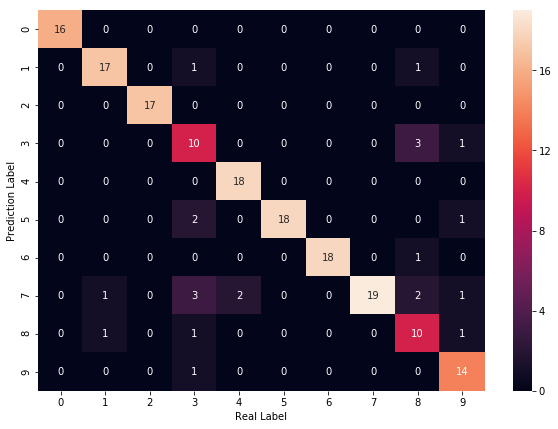

In [7]:
import seaborn as sn

df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, fmt='.20g', annot=True)
plt.xlabel('Real Label')
plt.ylabel('Prediction Label')
plt.show()

In [ ]:
def get_pred_real(i, j):
    winner_net = neat.nn.FeedForwardNetwork.create(winner_list[i], config)
    
    numbers = [*range(10)]
    class1 = classes[i]
    class2 = []
    class1_indexes = []
    class2_indexes = []
    
    test_X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[j]
    test_y = digits.target[j]

    list_y = [test_y]
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

    for i in numbers:
        if i in class1:
            class1_indexes.extend(digits_indexes[i])
        else:
            class2_indexes.extend(digits_indexes[i])
            class2.append(i)

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)


    testsamplesize = 1
    test_x_inputs =[tuple(test_X)]
    test_x_outputs = [tuple([c]) for c in class1_label + class2_label]

    outputs = []
    for xi in test_x_inputs:
        output = winner_net.activate(xi)
        outputs.append(output)

    px_outputs = softmax(np.array(outputs).reshape(testsamplesize, 2), axis=1)
    # the index of maximum in each line
    pred_outputs = np.argmax(px_outputs, axis = 1)

    
    return pred_outputs

In [22]:
pred_value = []
error_list = []

for j in range(1617,1617+180):
    pred = []
    for i in range(511):
        pred_outputs = get_pred_real(i, j)
        #print(pred_outputs, real_outputs)
        pred.append(pred_outputs)
    #print(np.array(pred).T)

    error = []
    for i in range(10):
        error.append(511 - np.sum(number_codes[i] == np.array(pred).T))
    #print(error)

    pred_value.append(np.where(error==np.min(error)))
    error_list.append(np.min(error))
    #print(np.where(error==np.min(error)) )

list_P = []
for i in pred_value:
    if (len(i[0])) == 1:
        list_P.append(i[0][0])
    else:
        random_pick = randint(0, len(i[0])-1)
        list_P.append(i[0][random_pick])

acc = np.sum(list_P == digits.target[1617:])/180
print(acc)

0.8722222222222222


In [24]:
i = 0
j = 1617

In [26]:
winner_net = neat.nn.FeedForwardNetwork.create(winner_list[i], config)

numbers = [*range(10)]
class1 = classes[i]
class2 = []
class1_indexes = []
class2_indexes = []

test_X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[j]
test_y = digits.target[j]

list_y = [test_y]
digits_indexes = []
for digit in numbers:
    li = [i for i in range(len(list_y)) if list_y[i] == digit]
    digits_indexes.extend([li])

for i in numbers:
    if i in class1:
        class1_indexes.extend(digits_indexes[i])
    else:
        class2_indexes.extend(digits_indexes[i])
        class2.append(i)

class1_label = [1] * len(class1_indexes)
class2_label = [0] * len(class2_indexes)


testsamplesize = 1
test_x_inputs =[tuple(test_X)]
test_x_outputs = [tuple([c]) for c in class1_label + class2_label]

outputs = []
for xi in test_x_inputs:
    output = winner_net.activate(xi)
    outputs.append(output)

px_outputs = softmax(np.array(outputs).reshape(testsamplesize, 2), axis=1)
# the index of maximum in each line
px_outputs
#pred_outputs = np.argmax(px_outputs, axis = 1)



array([[0.5, 0.5]])

In [28]:
np.argmax(px_outputs, axis = 1)

array([0])